# Emulating CLASS data

## Import Packages

In [2]:
import os
import numpy as np
import random

import pandas as pd
import time
import matplotlib.pyplot as plt

from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import plotting as pm
from looti import tools as too

In [3]:
%matplotlib inline

In [4]:
df1 = pd.read_csv('../data/mgcamb_z0.csv', index_col=list(range(14)))
df1

1  \
data_type redshift parameter_1 parameter_1_value parameter_2  parameter_2_value parameter_3 parameter_3_value parameter_4              parameter_4_value parameter_5 parameter_5_value parameter_6 parameter_6_value                
Plin      0.0      omega_m     0.312267          omega_baryon 0.046708          hubble      51.980833         scalar_spectral_index(1) 1.0712            sigma8      0.941435          log10fR0    -6.224293           120.838746   
                               0.294667          omega_baryon 0.039792          hubble      65.715833         scalar_spectral_index(1) 1.1080            sigma8      0.714069          log10fR0    -5.517489            30.787258   
                               0.372533          omega_baryon 0.059458          hubble      75.989167         scalar_spectral_index(1) 0.8280            sigma8      0.728280          log10fR0    -4.793015           160.075798   
                               0.282933          omega_baryon 0.053458          hubble      62.142500         scalar_spectral_index(1) 0.7672            sigma8      0.903067          log10fR0    -4.731169          1380.942516   
                               0.307467          omega_baryon 0.037875          hubble      76.100833         scalar_spectral_index(1) 0.7912            sigma8      0.775174          log10fR0    -4.740004           330.481207   
                               0.391733          omega_baryon 0.051958          hubble      53.990833         scalar_spectral_index(1) 0.7640            sigma8      1.022433          log10fR0    -4.607479           948.103495   
                               0.366667          omega_baryon 0.059875          hubble      63.147500         scalar_spectral_index(1) 1.0968            sigma8      0.795068          log10fR0    -4.916705            30.511117   
                               0.302133          omega_baryon 0.058625          hubble      56.894167         scalar_spectral_index(1) 1.1816            sigma8      0.671438          log10fR0    -6.047592            24.327575   
                               0.245600          omega_baryon 0.041958          hubble      72.862500         scalar_spectral_index(1) 0.8248            sigma8      0.809278          log10fR0    -6.489344           610.418330   
                               0.324533          omega_baryon 0.049042          hubble      53.320833         scalar_spectral_index(1) 1.1256            sigma8      0.999697          log10fR0    -6.003416            73.257560   
                               0.359200          omega_baryon 0.053708          hubble      80.790833         scalar_spectral_index(1) 0.8216            sigma8      1.065064          log10fR0    -4.404272           328.413325   
                               0.263200          omega_baryon 0.056292          hubble      77.217500         scalar_spectral_index(1) 0.9288            sigma8      1.062222          log10fR0    -4.015530           387.274440   
                               0.273867          omega_baryon 0.040792          hubble      63.035833         scalar_spectral_index(1) 0.8488            sigma8      0.716911          log10fR0    -6.135942           395.511208   
                               0.318133          omega_baryon 0.048042          hubble      74.537500         scalar_spectral_index(1) 0.7288            sigma8      0.839120          log10fR0    -6.568860           707.637503   
                               0.300000          omega_baryon 0.061292          hubble      82.130833         scalar_spectral_index(1) 1.0840            sigma8      0.675701          log10fR0    -3.989025            25.282050   
                               0.290400          omega_baryon 0.050875          hubble      61.472500         scalar_spectral_index(1) 1.1480            sigma8      0.643018          log10fR0    -5.915066            25.206126   
                               0.284533          omega_baryon 0.057125          hubble      74.984167 

# Import Data

In [5]:
data_folder = '../data/' 
results_folder = '../results/'

In [6]:
###Name of the file for the external input data, without the extension
datafile_ext = 'mgcamb_z0'
###Name of the file for the LCDM input data
datafile_ref = 'ref_mgcamb_z0'

In [7]:
emulation_data = dhl.DataHandle(datafile_ext, 
                                data_folder, 
                                datafile_ref, 
                                num_parameters=6, 
                                data_type='Plin',
                                features_name='k_grid', 
                                features_to_Log=True, 
                                ratio_mode=False) 
emulation_data.read_csv_pandas()

## Calculate power spectra ratios at all redshifts available

In [8]:
## Set normalize=False, since Fitting Formulae are already normalized
## First argument contains all the redshifts at which simulations are available
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals, normalize=True)

# Define number of training and test

In [9]:
### Available parameters 
n_train = 25 # Number of training vectors without taking acount the extrema 
n_test = 3 # Number of test vectors without taking acount the extrema
n_splits = 3  # Number of splits
test_indices=[random.sample(range(1, 1000), n_test), random.sample(range(1, 1000), n_test), random.sample(range(1, 1000), n_test)]  ## List of list of indices, one list per split

In [10]:
emulation_data.calculate_data_split(n_train=n_train, ##number of training vectors/ redshift
                                    n_test=n_test, ##number of test vectors
                                    n_splits=n_splits,
                                    verbosity=3,
                                    manual_split=True,
                                    test_indices=None,
                                    train_redshift_indices=[0],##Indices of the redshifts used for the train vect.
                                    test_redshift_indices=[0]) ##Indices of the redshifts used for the test vect.

('number of wanted training vectors', 25)
('number of wanted test vectors', 3)
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))
('redshift used for training', array([0.]))
('redshfit used for testing', array([0.]))


In [11]:
emulation_data.train_redshift

array([0.])

#  PCA with GP interpolation

In [12]:
npca = 7
nparam = 6

In [13]:
ratios_predicted , emulation_data, intobj = dcl.Predict_ratio(emulation_data,Operator="PCA",
                                                              train_noise=1e-10, ##noise for the GP's kernel
                                                              gp_n_rsts=40,##times allowed to restart the optimiser
                                                              ncomp=npca, ##number of components
                                                              gp_const=1, ##Constant for the RBF kernel
                                                              gp_length=np.ones(nparam) , ## Length for GP 
                                                              interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                              n_splits=n_splits, ##number of splits
                                                              test_indices=test_indices, ##indices of the test vectors
                                                              interp_dim=1,
                                                              return_interpolator=True,
                                                              pca_norm=True,
                                                              train_redshift_indices=[0],
                                                              test_redshift_indices=[0]
                                                              # min_k =1e-2,ma_k=10e1
                                                              )

('Shape of PCA matrix: (25, 7)',)
('Number of PCA components: 7',)


In [14]:
# import pickle
# filename = 'gp_Plin.sav'
# pickle.dump(intobj, open(filename, 'wb'))

In [15]:
colors = plt.cm.coolwarm(np.linspace(0, 1, n_train +2))
colors_pca = plt.cm.coolwarm(np.linspace(0, 1, npca))
kgrid = emulation_data.k_grid

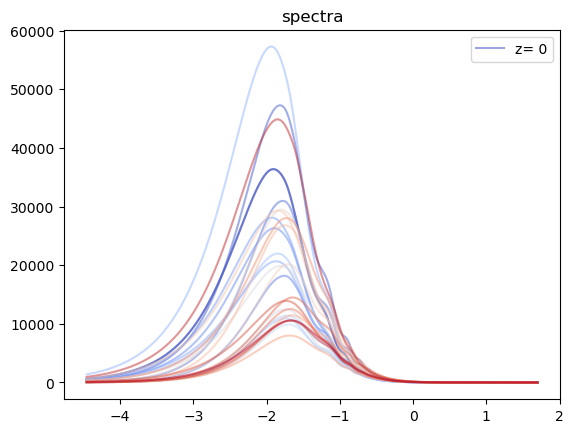

In [16]:
spectra = emulation_data.df_ext.loc['Plin'].values
for i, (spec, color) in enumerate(zip(spectra, colors)):
    if i == 0:
        plt.plot(kgrid, spec, c=color, alpha=0.5, label='z= %i' %emulation_data.z_requested[i])
    plt.plot(kgrid, spec, c=color, alpha=0.5)
plt.title('spectra')
plt.legend()

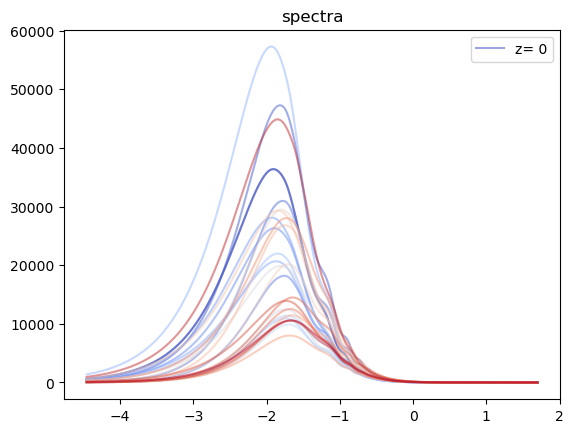

In [17]:
spectra = emulation_data.df_ext.loc['Plin'].values
for i, (spec, color) in enumerate(zip(spectra, colors)):
    if i == 0:
        plt.plot(kgrid, spec, c=color, alpha=0.5, label='z= %i' %emulation_data.z_requested[i])
    plt.plot(kgrid, spec, c=color, alpha=0.5)
plt.title('spectra')
plt.legend()

TRAINING DATA: (25, 800)


Text(0.5, 1.0, 'spectra normed')

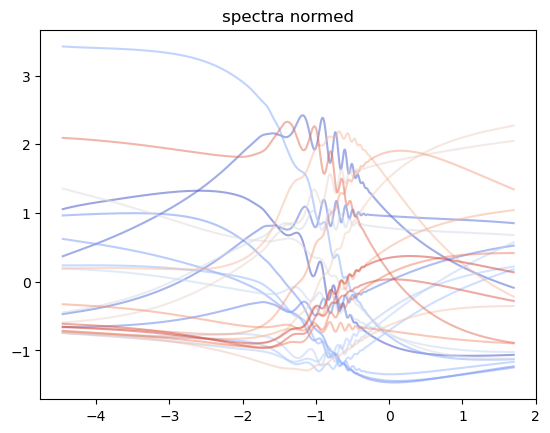

In [19]:
trainspace_matrix = intobj.trainspace_mat
print('TRAINING DATA:', trainspace_matrix.shape)
for spec, color in zip(trainspace_matrix, colors):
    plt.plot(kgrid, spec, c=color, alpha=0.5)
plt.title('spectra normed')

PCA RAW: (25, 7)


Text(0.5, 1.0, 'pca')

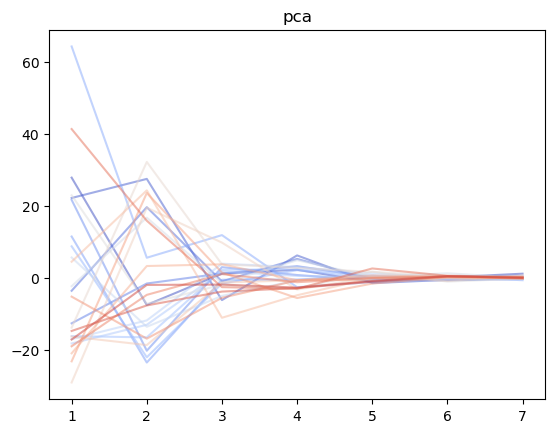

In [20]:
pca_raw = intobj.pca.fit(trainspace_matrix).transform(trainspace_matrix)
print('PCA RAW:', pca_raw.shape)
for pcar, color in zip(pca_raw, colors):
    plt.plot(np.linspace(1, npca, npca), pcar, c=color, alpha=0.5)
plt.title('pca')

PCA: (25, 7)


Text(0.5, 1.0, 'pca normed')

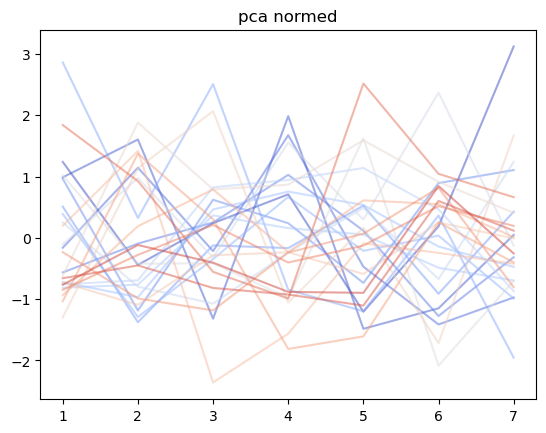

In [21]:
pca_test = intobj.representation
print('PCA:', pca_test.shape)
for pca, color in zip(pca_test, colors):
    plt.plot(np.linspace(1, npca, npca), pca, c=color, alpha=0.5)
plt.title('pca normed')

Text(0, 0.5, 'Normed Input Values')

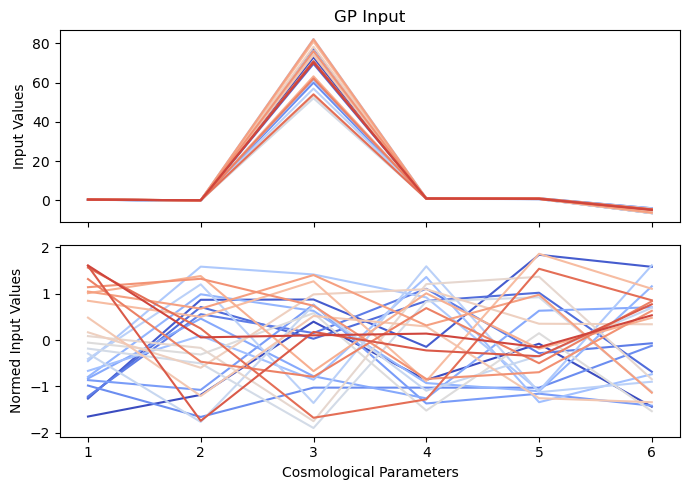

In [22]:
trainspace_raw = intobj.trainspace
trainspace_normed = (trainspace_raw - trainspace_raw.mean(axis=0)) / trainspace_raw.std(axis=0)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)

for tsr, color in zip(trainspace_raw, colors):
    ax[0].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[0].set_ylabel('Input Values')
ax[0].set_xticklabels([])
ax[0].set_title('GP Input')


for tsr, color in zip(trainspace_normed, colors):
    ax[1].plot(np.linspace(1, nparam, nparam), tsr, c=color)
ax[1].set_xlabel('Cosmological Parameters')
ax[1].set_ylabel('Normed Input Values')

In [23]:
plot_index = 20

Text(0, 0.5, 'Residuals')

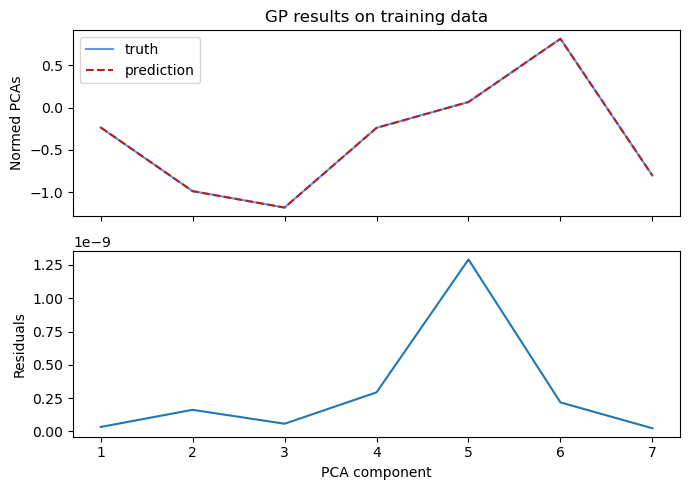

In [24]:
xtrain = (emulation_data.train_samples - emulation_data.train_samples.mean(axis=0)) / emulation_data.train_samples.std(axis=0)
prediction_pca_normed = intobj.gp_regressor.predict(xtrain)
truth_pca_normed = intobj.representation
fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_normed[plot_index], c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_normed[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1- (prediction_pca_normed/truth_pca_normed))
ax[1].plot(np.linspace(1, npca, npca), residuals[plot_index])
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')

Text(0, 0.5, 'Residuals')

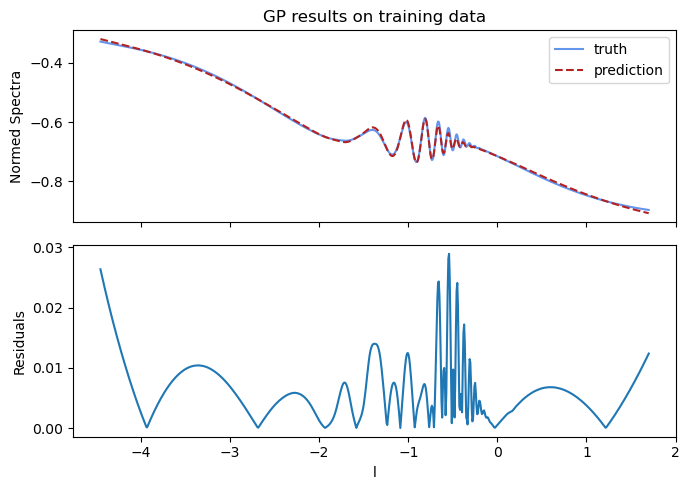

In [25]:
truth_spectrum_normed_train = intobj.trainspace_mat[plot_index]
prediction_spectrum_normed_train = intobj.reconstruct_data(emulation_data.train_samples, pca_norm=True)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_normed_train, c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_normed_train, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1- (prediction_spectrum_normed_train/truth_spectrum_normed_train))
ax[1].plot(kgrid, residuals)
ax[1].set_xlabel('l')
ax[1].set_ylabel('Residuals')

In [40]:
binwise_mean = emulation_data.binwise_mean
binwise_std = emulation_data.binwise_std
ref = emulation_data.df_ref.loc['Plin', 0.0].values

Text(0, 0.5, 'Residuals')

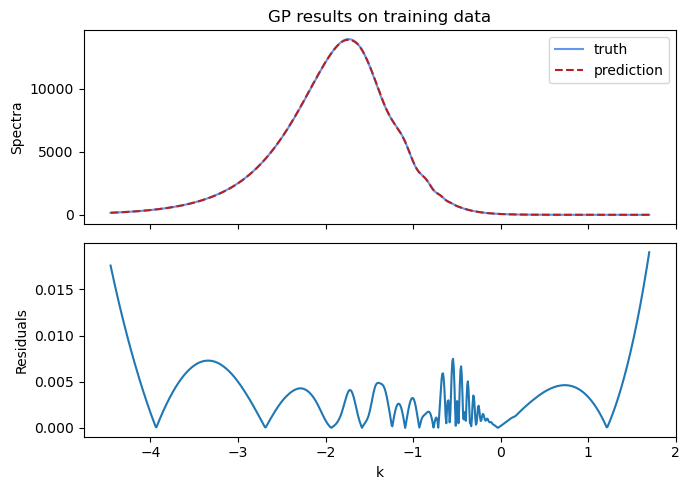

In [41]:
truth_spectrum_train = (truth_spectrum_normed_train * binwise_std + binwise_mean) * ref
prediction_spectrum_train = (prediction_spectrum_normed_train * binwise_std + binwise_mean) * ref


fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_train.flatten(), c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_train.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on training data')

residuals = np.abs(1 - prediction_spectrum_train.flatten() / truth_spectrum_train.flatten())
ax[1].plot(kgrid, residuals)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Residuals')

In [32]:
indexvalues = emulation_data.test_samples[plot_index]

truth_spectrum = emulation_data.df_ext.loc['Plin', 0.0, 'omega_m', indexvalues[0], 'omega_baryon', indexvalues[1], 'hubble', indexvalues[2], 'scalar_spectral_index(1)', indexvalues[3], 'sigma8', indexvalues[4], 'log10fR0', indexvalues[5]].values.flatten()

ref_spectrum = emulation_data.df_ref.loc['Plin', 0.0].values.flatten()
# ref_spectrum = 1

truth_spectrum_normed = (truth_spectrum/ref_spectrum - emulation_data.binwise_mean) / emulation_data.binwise_std
prediction_spectrum_normed = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]

In [33]:
indexvalues = emulation_data.test_samples[plot_index]

truth_spectrum_test = emulation_data.df_ext.loc['Plin', 0.0, 
                                                'omega_m', indexvalues[0], 
                                                'omega_baryon', indexvalues[1], 
                                                'hubble', indexvalues[2], 
                                                'scalar_spectral_index(1)', indexvalues[3], 
                                                'sigma8', indexvalues[4], 
                                                'log10fR0', indexvalues[5]].values.flatten()

ref_spectrum = emulation_data.df_ref.loc['Plin', 0.0].values.flatten()
truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)

In [34]:
truth_normed_pcas_list = []

for ii in range(emulation_data.test_samples.shape[0]):
    indexvalues = emulation_data.test_samples[ii]

    truth_spectrum_test = emulation_data.df_ext.loc['Plin', 0.0, 
                                                    'omega_m', indexvalues[0], 
                                                    'omega_baryon', indexvalues[1], 
                                                    'hubble', indexvalues[2], 
                                                    'scalar_spectral_index(1)', indexvalues[3], 
                                                    'sigma8', indexvalues[4], 
                                                    'log10fR0', indexvalues[5]].values.flatten()
    ref_spectrum = emulation_data.df_ref.loc['Plin', 0.0].values.flatten()

    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std
    truth_pca_test_raw = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj.matPCA_mean) / intobj.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

IndexError: index 7 is out of bounds for axis 1 with size 7

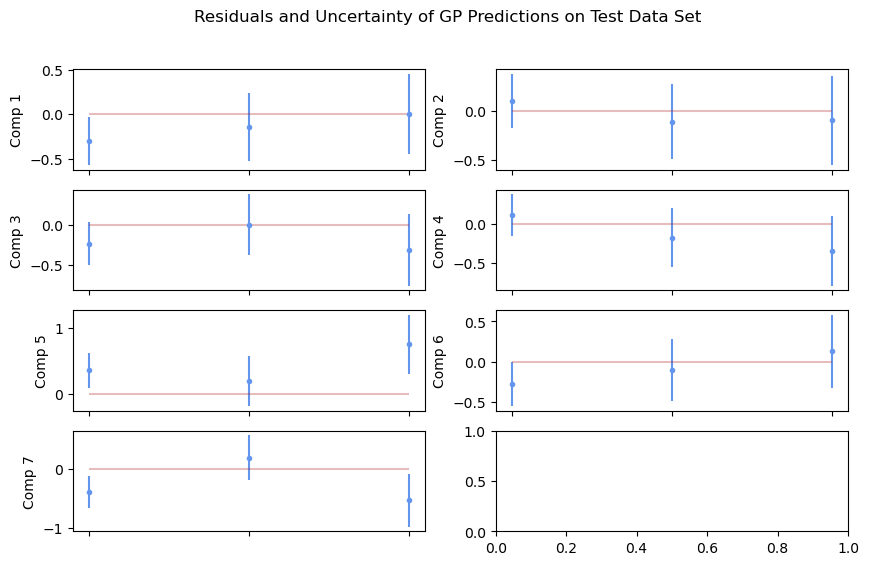

In [35]:
n_test = emulation_data.test_samples.shape[0]
grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(npca/2)), ncols=2, figsize=(10,6))
#plt.subplots_adjust(hspace=0.5)
fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp, ax in enumerate(axs.ravel()):
    ax.errorbar(grid, 
                 truth_normed_pcas[:,comp]-prediction_pca_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    ax.hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    ax.set_ylabel("Comp %i" %(comp+1))
    ax.set_xticks(list(range(1,n_test+1)))
    ax.set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

In [36]:
plot_index =0

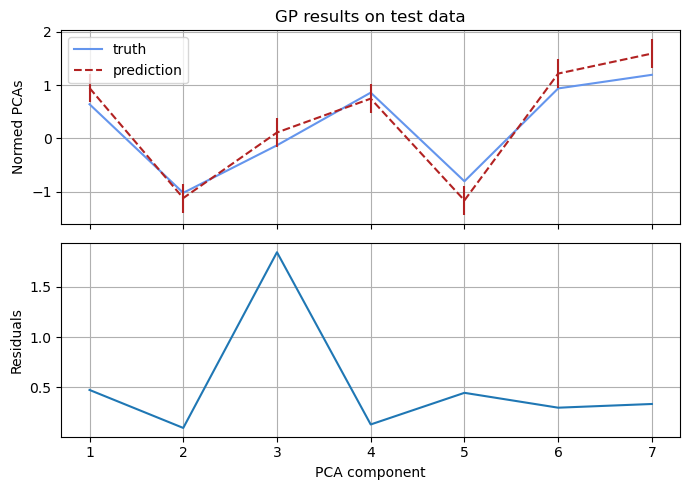

In [37]:
indexvalues = emulation_data.test_samples[plot_index]
# truth_spectrum_test = emulation_data.df_ext.loc['Plin', indexvalues[0], 
#                                                 'omega_m', indexvalues[1], 
#                                                 'omega_baryon', indexvalues[2], 
#                                                 'hubble', indexvalues[3], 
#                                                 'scalar_spectral_index(1)', indexvalues[4], 
#                                                 'sigma8', indexvalues[5], 
#                                                 'log10fR0', indexvalues[6]].values.flatten()
# ref_spectrum = emulation_data.df_ref.loc['Plin', indexvalues[0]].values.flatten()

truth_spectrum_test = emulation_data.df_ext.loc['Plin', 0.0, 
                                                'omega_m', indexvalues[0], 
                                                'omega_baryon', indexvalues[1], 
                                                'hubble', indexvalues[2], 
                                                'scalar_spectral_index(1)', indexvalues[3], 
                                                'sigma8', indexvalues[4], 
                                                'log10fR0', indexvalues[5]].values.flatten()
ref_spectrum = emulation_data.df_ref.loc['Plin', 0.0].values.flatten()

truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data.binwise_mean) / emulation_data.binwise_std

truth_pca_test1 = intobj.pca.transform([truth_spectrum_normed_test]).flatten()
truth_pca_test = (truth_pca_test1 - intobj.matPCA_mean) / intobj.matPCA_std
xtest = (emulation_data.test_samples - intobj.trainspace_mean) / intobj.trainspace_std
prediction_pca_test, std_pca_test = intobj.gp_regressor.predict(xtest, return_std=True)
# prediction_pca_test = intobj.interpolated_atoms(xtest)[plot_index]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(np.linspace(1, npca, npca), truth_pca_test, c='cornflowerblue', label='truth')
ax[0].plot(np.linspace(1, npca, npca), prediction_pca_test[plot_index], c='firebrick', linestyle='--', label='prediction')
ax[0].errorbar(np.linspace(1, npca, npca), prediction_pca_test[plot_index], yerr=std_pca_test[plot_index], linestyle='', color='firebrick')
ax[0].legend()
ax[0].set_ylabel('Normed PCAs')
ax[0].set_xticks(np.arange(1, npca+1))
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
ax[0].grid()

residuals_pca = np.abs(1- (prediction_pca_test[plot_index]/truth_pca_test))
ax[1].plot(np.linspace(1, npca, npca), residuals_pca)
ax[1].set_xticks(np.arange(1, npca+1))
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
ax[1].grid()

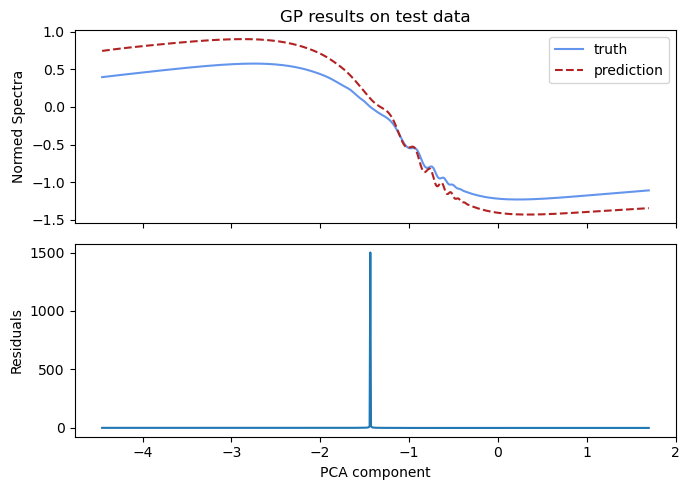

In [38]:
prediction_spectrum_normed_test = intobj.predict(emulation_data.test_samples, pca_norm=True)[tuple(indexvalues)]
# prediction_spectrum_normed = ratios_predicted[tuple(emulation_data.test_samples[plot_index])]

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_normed_test, c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_normed_test, c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Normed Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')
# ax[0].hlines(0, 1, 2499, color='black', alpha=0.3)

residuals_norm = np.abs(1 - prediction_spectrum_normed_test / truth_spectrum_normed_test)
ax[1].plot(kgrid, residuals_norm)
ax[1].set_xlabel('PCA component')
ax[1].set_ylabel('Residuals')
plt.show()

Text(0, 0.5, 'Residuals')

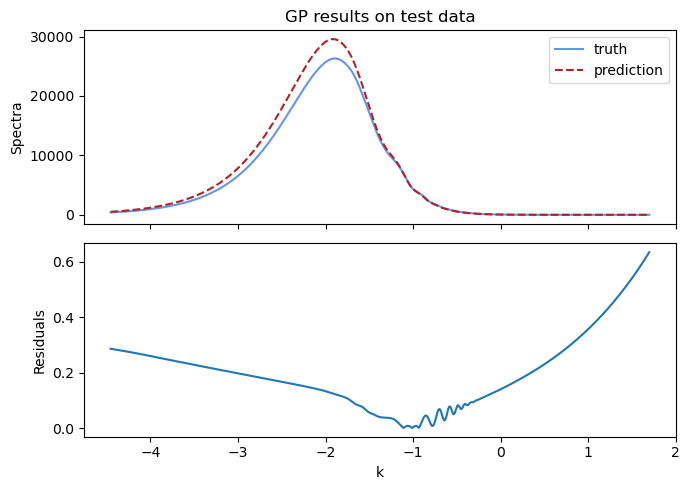

In [39]:
prediction_spectrum_test = (prediction_spectrum_normed_test * binwise_std + binwise_mean) * ref_spectrum
# prediction_spectrum_test = dcl.reconstruct_spectra(prediction_spectrum_normed_test, emulation_data)

fig, ax =plt.subplots(2, figsize=(7, 5))
fig.set_tight_layout(tight=True)
ax[0].plot(kgrid, truth_spectrum_test, c='cornflowerblue', label='truth')
ax[0].plot(kgrid, prediction_spectrum_test.flatten(), c='firebrick', linestyle='--', label='prediction')
ax[0].legend()
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[0].set_title('GP results on test data')

residuals = np.abs(1 - prediction_spectrum_test.flatten() / truth_spectrum_test)
ax[1].plot(kgrid, residuals)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Residuals')

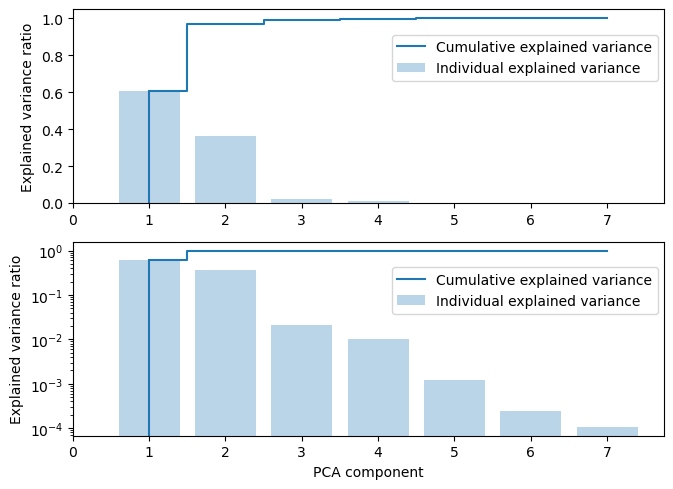

In [65]:
pca = intobj.pca

X_train_pca = pca.fit_transform(trainspace_matrix)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
fig, ax = plt.subplots(2, figsize=(7, 5))
ax[0].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[0].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[0].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xticks(list(range(npca+1)))
ax[0].legend(loc=(0.54, 0.63))

ax[1].step(range(1, len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
ax[1].bar(range(1, len(exp_var_pca)+1), exp_var_pca, alpha=0.3, align='center', label='Individual explained variance')
ax[1].vlines(x=1, ymin=0, ymax=cum_sum_eigenvalues[0])
ax[1].set_ylabel('Explained variance ratio')
ax[1].set_xlabel('PCA component')
ax[1].set_yscale('log')
ax[1].set_xticks(list(range(npca+1)))
ax[1].legend(loc=(0.54, 0.63))
plt.tight_layout()
plt.show()

In [38]:
# import pickle
# filename = 'gp_Plin_z0to2.sav'
# pickle.dump(intobj, open(filename, 'wb'))